# Word Embeddings and Neural Text Classifiers

In this section use both sparse vectors and dense word2vec embeddings are used to obtain
vector representations of words and documents. 

This uses the `tweet eval` offensive speech dataset. This is a binary classification task, where the aim is to classify text as offensive or not. Some examples are controversial, which adds additional challenge. 

In [82]:
import numpy as np
import torch
from datasets import load_dataset
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import word2vec
from gensim.utils import tokenize
import gensim.downloader
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
cache_dir = "./data_cache"

train_dataset = load_dataset(
    "tweet_eval",
    name="offensive",
    split="train",
    cache_dir=cache_dir,
)

print(f"Training dataset with {len(train_dataset)} instances loaded")


dev_dataset = load_dataset(
    "tweet_eval",
    name="offensive",
    split="validation",
    cache_dir=cache_dir,
)

print(f"Development/validation dataset with {len(dev_dataset)} instances loaded")


test_dataset = load_dataset(
    "tweet_eval",
    name="offensive",
    split="test",
    cache_dir=cache_dir,
)

print(f"Test dataset with {len(test_dataset)} instances loaded")

# Put the data into lists ready for the next steps...
train_texts = []
train_labels = []
for i in tqdm(range(len(train_dataset))):
    train_texts.append(train_dataset[i]['text'])
    train_labels.append(train_dataset[i]['label'])
            
# HINT: A count vectorizer object may be useful in later steps
vectorizer = CountVectorizer()
vectorizer.fit(train_texts)

# Get the vocabulary
vocab = vectorizer.vocabulary_
vocab_size = len(vocab)
print(f'The vocabulary has {vocab_size} words')

# invert the vocabulary dictionary so we can look up word types given an index
keys = vocab.values()
values = vocab.keys()
vocab_inverted = dict(zip(keys, values))

print(f'Index of "love" is {vocab["love"]}')

Training dataset with 11916 instances loaded
Development/validation dataset with 1324 instances loaded
Test dataset with 860 instances loaded


100%|██████████| 11916/11916 [00:00<00:00, 34282.64it/s]


The vocabulary has 18010 words
Index of "love" is 9702


## 1.1. Term-Document Matrix

First we obtain sparse word vectors from a term-document matrix.

Here we use CountVectorizer to obtain a term-document matrix for the training set. Then, we have a function that takes a word as an argument and returns its term vector from the term-document matrix you computed. As an example we get the term vector for the word 'lying', which may sometimes be associated with offensive text.

In [84]:
# generating a term-document matrix for the training data using the count vectorizer from sklearn
vectorizer = CountVectorizer()
term_document_matrix = vectorizer.fit_transform(train_texts)

# A function that will take a word, look up its index in the vocabulary of the vectorizer, and return the term vector for that word
def get_word_vector(word):
    vocabulary = vectorizer.vocabulary_
    word_column = vocabulary[word]
    # flatten is used to ensure the output is always a 1D array
    vector = term_document_matrix[:, word_column].toarray().flatten()
    return(vector)

# call the function to get the term vector for the word 'lying'
get_word_vector('lying')

array([0, 0, 0, ..., 0, 0, 0])

In [85]:
# Define a list of words for comparison with 'lying' in the next to-do.
comparison_words = [
'squalor',
'climbing',
'lining',
'harf',
'outright',
'bud',
'tooo',
'subpoenaed',
'estate',
'jaclyn',
'ladder',
'nutjob',
'scarborough',
'antifascism',
'presumably',
'lying',
'bullsh',
'sombody',
'humiliated',
'is',
'weight',
'faiths',
'semite',
'mondy',
'licked',
'garak',
'wants',
'sullied',
'qalert',
'sleaze',
'frankly',
'civilians',
'roles',
'sticking',
'meltdown',
'children',
'robotic',
'idiotalert',
'unto',
'presentation',
'vicki',
'brag',
'three',
'macy',
'diplomacy',
'blight',
'masturbate',
'cheater',
'shallow',
'mensch',
'harshest',
'birds',
'cultivated',
'warming',
'dummy',
'totalitarianism',
'thgs',
'restrictions',
'place',
'jfk',
'blabber',
'ww2',
'investing',
'enabler',
'mango',
'suspicion',
'goober',
'chaplain',
'dish',
'colluding',
'cincy',
'sutherland',
'leader',
'sporting',
'christianity',
'happens',
'fought4',
'sidelines',
'bashthefash',
'corrected',
'murdoch',
'movie',
'increased',
'undies',
'passions',
'whos',
'profiles',
'lots',
'diners',
'blade',
'dipshits',
'welles',
'midriff',
'signage',
'foodnetwork',
'sooooo', 
'however', 
'younger', 
'aint', 
'supposedly'
]


This function computes the similarity between two different term vectors. We then use the function to find the five most similar terms to "love" from the list of `comparison_words` given above.

$\text{similarity}(X,Y) = \cos(\theta) = \frac{X \cdot Y}{||X|| \space ||Y||}$

$||X||$ is the magnitude of vector $X$, $||X|| = \sqrt{X^2_1 + X^2_1 ... X^n_1}$

In [86]:
def vector_cosine_similarity(X,Y):
    # dot product
    dot_product = np.dot(X,Y)
    # magintudes
    X_mag = np.sqrt(np.sum(X**2))
    Y_mag = np.sqrt(np.sum(Y**2))
    # cosine similarity
    similarity = dot_product / (X_mag * Y_mag)
    return(similarity)

def similar_words(given_word, n):
    given_vector = get_word_vector(given_word)
    similarities = []

    for word in comparison_words:
        comparison_vector = get_word_vector(word)
        similarity = vector_cosine_similarity(given_vector, comparison_vector)
        similarities.append((similarity,word))

    similarities.sort(key=lambda x: x[0], reverse=True)
    top_n = similarities[:n]
    return([word for _, word in top_n])

similar_words('love',5)

['is', 'midriff', 'semite', 'presentation', 'aint']

## 1.2 Word Embeddings

Now, we will use Gensim to train a word2vec model. The code below tokenizes the training texts, then runs word2vec (the skipgram model) to learn a set of embeddings. 

In [87]:
tokenized_texts = [list(tokenize(text)) for text in train_texts]
emb_model = word2vec.Word2Vec(tokenized_texts, sg=1, min_count=1, window=3, vector_size=100)

In [88]:
# get the word vector for 'love'
love_embedding = emb_model.wv['love']

Here we find the five most similar words to 'lying' according to your word2vec model. We can use the Gensim function `similar_by_word` to do this. We can then compare how Word2Vec top 5 differ from the top 5 comparison words found using the term-document matrix?

The 5 most similar words are:
- guilty
- victim
- evil
- innocent
- upset

Word2Vec is able to preserve the semantic meanings and realtionships between words. This means the top 5 words a chosen based on their contextual usage. Term-document matrix just uses the frequecy of terms so will not captuire context. The top 5 words here are the ones that appear most frequently together in the same document. 


In [89]:
emb_model.wv.similar_by_word('lying',5)

[('dead', 0.9827289581298828),
 ('telling', 0.9823184013366699),
 ('horrible', 0.982153594493866),
 ('half', 0.9812731146812439),
 ('making', 0.9796337485313416)]

Above, we trained our own model using the skipgram method. We can also download a pretrained model that has previously been trained on a large corpus. There is a list of models available [here](https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models). Here we will try out GLoVe embeddings. GLoVe is an alternative to the skipgram model. This model was trained on a corpus of tweets:

In [90]:
glove_wv = gensim.downloader.load('glove-twitter-25')

# show the vector for love:
print(glove_wv['love'])

[-0.62645  -0.082389  0.070538  0.5782   -0.87199  -0.14816   2.2315
  0.98573  -1.3154   -0.34921  -0.8847    0.14585  -4.97     -0.73369
 -0.94359   0.035859 -0.026733 -0.77538  -0.30014   0.48853  -0.16678
 -0.016651 -0.53164   0.64236  -0.10922 ]


Here we show the most similar five words to 'happy' according to the GloVe Twitter model.

In [91]:
glove_wv.similar_by_word('happy',5)

[('birthday', 0.9577818512916565),
 ('thank', 0.937666654586792),
 ('welcome', 0.9336148500442505),
 ('love', 0.9176183342933655),
 ('miss', 0.9164500832557678)]

Notice again that a different set of words are favoured than with word2vec or term-document vectors, and consider how this might result from pretraining the embeddings on Twitter data.

# 2. Neural Text Classifiers

This section shows how to implement a neural network classifier using Pytorch and leads you through the steps required to process text sequences.

There are several big advantages to building a text classifier using a neural network:
   * It can model nonlinear functions, so can handle much more complex relationships between features and class labels.
   * It performs representation learning: the hidden layers learn how to extract features from low-level data.
   * It can process sequences of tokens -- we don't have to think in terms of a single feature vector representing a document as we did for logistic regression.
  
The downsides are:
   * Much more expensive to train and test.
   * It can overfit very badly to small datasets.
   * The features learned by the hidden layers can be hard to interpret, which can make it hard to predict the model's behaviour, e.g., what sort of cases it may fail on.
   
Let's start by building a neural network text classifier that takes a sequence of tokens as input, and predicts a class label. For simplicity, it will use a single fully connected feedforward layer. 


We are going to construct the neural network in this form:

<img src="neural_text_classifier_smaller.png" alt="Neural text classifier diagram" width="600px"/>

The first step -- as always -- is to get our data into the right format. We start from a set of tokenised documents (in this case, tweets), where each document is represented as a sequence of text tokens. The neural network cannot process the tokens as strings, so we need to convert each token to a numerical input value. The input value for each token is used to look up the corresponding embedding in the embedding layer. For PyTorch, it's not necessary to create one-hot vectors for each token, as library just uses the indexes of the words in the vocabulary to look up the corresponding word embedding. 

So, let's now map the tokens to their IDs -- their indexes in the vocabulary:

In [92]:
# tokenize training set and convert to input IDs.
def encode_text(sample):
    tokens = tokenize(sample['text'])  # Tokenize one document
    
    input_ids = []
    for token in tokens:
        if str.lower(token) in vocab:  # Skip words from the dev/test set that are not in the vocabulary.
            input_ids.append(vocab[str.lower(token)]+1) # +1 is needed because we reserve 0 as a special character
            
    sample['input_ids'] = input_ids 
    return sample

# The map method of the dataset object takes a function as its argument, 
# and applies that function to each document in the dataset.
train_dataset = train_dataset.map(encode_text)
len(train_dataset)

11916

Our neural network's input layer has a fixed size, so we need to make all of our documents have the same number of tokens. Let's plot a histogram to understand the length distribution of the texts in the training set:

Mean of the document length: 21.12294394091977
Median of the document length: 17.0
Maximum document length: 101


(array([3502., 3421., 2006., 1384., 1165.,  366.,   41.,   12.,   10.,
           9.]),
 array([  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101.]),
 <BarContainer object of 10 artists>)

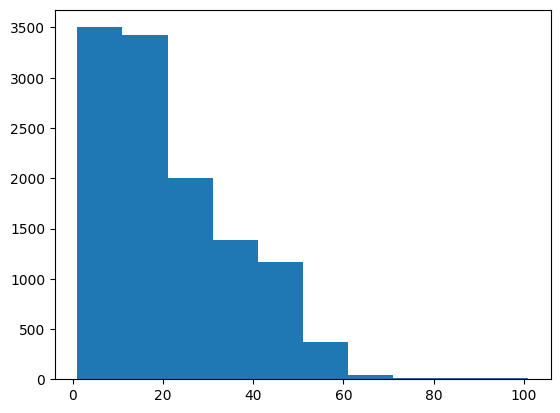

In [93]:
rv_l = [len(doc) for doc in train_dataset['input_ids']]
print('Mean of the document length: {}'.format(np.mean(rv_l)))
print('Median of the document length: {}'.format(np.median(rv_l)))
print('Maximum document length: {}'.format(np.max(rv_l)))

plt.hist(rv_l)

We now need to choose a fixed sequence length, then *pad* the documents that are shorter than this maximum by adding a special token to the start of the sequence. The special pad token has an input value of 0. Any documents that exceed the length will be truncated.

Here we complete the padding code below to insert 0s at the start of any sequences that are too short, and to truncate any sequences that are too long.

In [94]:
sequence_length = 60  # truncate all docs longer than this. Pad all docs shorter than this.

def pad_text(sample):
    sample = sample['input_ids'] 
    if sequence_length >= len(sample):
        for i in range(sequence_length - len(sample)):
            sample = [0] * (sequence_length - len(sample)) + sample
    else:
        sample = sample[:sequence_length]
    sample = {'input_ids': sample}
    return sample

# The map method will call pad_text for every document in the dataset
train_dataset = train_dataset.map(pad_text)

We now have our data in almost the right format! To train a model using PyTorch, we are going to wrap our dataset in a [DataLoader object](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). This allows the training process to select random subsets of the dataset -- mini-batches -- which it will use for learning with mini-batch stochastic gradient descent.

In [95]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64

# convert from the Huggingface format to a TensorDataset so we can use the mini-batch sampling functionality
def convert_to_data_loader(dataset, num_classes):
    # convert from list to tensor
    input_tensor = torch.from_numpy(np.array(dataset['input_ids']))
    label_tensor = torch.from_numpy(np.array(dataset['label'])).long()
    tensor_dataset = TensorDataset(input_tensor, label_tensor)
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    return loader

num_classes = len(np.unique(train_labels))   # number of possible labels in the sentiment analysis task

train_loader = convert_to_data_loader(train_dataset, num_classes)

In [96]:
num_classes

2

Let's process the development and test set as well.

In [97]:
dev_dataset = dev_dataset.map(encode_text)
dev_dataset = dev_dataset.map(pad_text)
dev_loader = convert_to_data_loader(dev_dataset, num_classes)

test_dataset = test_dataset.map(encode_text)
test_dataset = test_dataset.map(pad_text)
test_loader = convert_to_data_loader(test_dataset, num_classes)

As shown in the diagram above, we will build a NN with three different layers for sentiment classification.

### Embedding layer
In the embedding layer, the network will create its own embeddings for the index with a given embedding dimension.
The module `nn.Embedding()` creates a simple lookup table that stores embeddings of a fixed dictionary and size.
This module is often used to store word embeddings and retrieve them using indices.
The module's input is a list of indices, and the output is the corresponding word embeddings.

[Documentation for Embedding Class](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)

### Fully-connected layer
Fully-connected layers in a neural network are those layers where all the inputs from the previous layer are connected to every unit of the fully-connected layer. Here we will use fully-connected layers for the hidden layer and output layer. In Pytorch this kind of layer is implemented by the 'Linear' class:

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

## Activation functions
In Pytorch, the activation function is not included in the Linear class (or other kinds of neural network layer), so we need to explicitly connect each layer to an activation function.
In Pytorch, we construct a neural network by connecting up the output of each component to the input of the next, thereby creating a computation graph.
To complete the hidden layer, we connect the ouput of the linear layer to a ReLU activation function, thereby creating a nonlinear function.

The cell below defines a class for our neural text classifier. The constructor creates each of the layers and the activations. The dimensions of each layer need to be correct so that the output of one layer can be passed as input to the next, but the code is not yet complete.

Below the constructor is the forward method. This is called in the 'forward pass' to map the neural network's inputs to its outputs. In PyTorch, we pass data through each layer of the model, connecting them together, then returning the output of the final layer.

Here we complete the constructor and the forward method below for a NN with three layers. The places where you need to add code are marked in the cell below. Refer to the Pytorch documentation for additional help.

In [98]:
from torch import nn

class FFTextClassifier(nn.Module):
    
    def __init__(self, vocab_size, sequence_length, embedding_size, hidden_size, num_classes):
        super(FFTextClassifier, self).__init__()

        self.embedding_size = embedding_size

        # Here we just need to construct the components of our network. We don't need to connect them together yet.
        self.embedding_layer = nn.Embedding(vocab_size, embedding_size) # embedding layer
        
        ### COMPLETE THE CODE HERE: WRITE IN THE MISSING ARGUMENTS SPECIFYING THE DIMENSIONS OF EACH LAYER
        self.hidden_layer = nn.Linear(self.embedding_size*sequence_length,hidden_size) # Fully connected hidden layer
        self.activation = nn.ReLU() # Hidden layer
        ##########
        
        self.output_layer = nn.Linear(hidden_size, num_classes) # Fully connected output layer

        
        
    def forward (self, input_words):
        # Input dimensions are:  (batch_size, seq_length)
        embedded_words = self.embedding_layer(input_words)  # (batch_size, seq_length, embedding_size)

        # flatten the sequence of embedding vectors for each document into a single vector.
        embedded_words = embedded_words.reshape(embedded_words.shape[0], sequence_length*self.embedding_size)  # batch_size, seq_length*embedding_size

        z = self.hidden_layer(embedded_words)   # (batch_size, hidden_size)
        
        ### ADD THE MISSING LINE HERE
        h = self.activation(z)
        ########

        output = self.output_layer(h)                      # (batch_size, num_classes)

        # Notice we haven't applied a softmax activation to the output layer -- it's not required by Pytorch's loss function.

        return output

Now the class is complete. 

In the next cell, we create a NN with the FFTextClassifier class we wrote.

In [99]:
vocab_size = len(vectorizer.vocabulary_) + 1
embedding_size = 10  # number of dimensions for embeddings
hidden_size = 8 # number of hidden units

model = FFTextClassifier(vocab_size, sequence_length, embedding_size, hidden_size, num_classes)

After desigining our network, we need to create a training function to calculate the loss for each input and perform backpropagation to optimise the network.
During training, the weights of all the layers will be updated.

Below, we build a training function to train the NN over a fixed number of epochs (an epoch is one iteration over the whole training dataset).
The function also prints the performance of both training and development/validation set after each epoch.

Here we use cross-entropy loss, which is the standard loss function for classification that we also used for logistic regression. The module `nn.CrossEntropyLoss()` operates directly on the output of our output layer, so we don't have to implement the softmax layer within the forward() method.

Cross Entropy Loss: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

The optimizer object implements a particular algorithm for updating the weights. Here, we will use the Adam optimizer, which is a variant of stochastic gradient descent method that tends to find a better solution in a smaller number of iterations than standard SGD.

Optimization: https://pytorch.org/docs/stable/optim.html

The cell below defines a training function for our classifier:

In [100]:
from torch import optim

def train_nn(num_epochs, model, train_dataloader, dev_dataloader):
    
    learning_rate = 0.0005  # learning rate for the gradient descent optimizer, related to the step size

    loss_fn = nn.CrossEntropyLoss()  # create loss function object
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # create the optimizer
    
    all_train_losses = []
    all_dev_losses = []
    
    for e in range(num_epochs):
        # Track performance on the training set as we are learning...
        total_correct = 0
        total_trained = 0
        train_losses = []

        model.train()  # Put the model in training mode.

        for i, (batch_input_ids, batch_labels) in enumerate(train_dataloader):
            # Iterate over each batch of data
            # print(f'batch no. = {i}')

            optimizer.zero_grad()  # Reset the optimizer

            # Use the model to perform forward inference on the input data.
            # This will run the forward() function.
            output = model(batch_input_ids)

            # Compute the loss for the current batch of data
            batch_loss = loss_fn(output, batch_labels)

            # Perform back propagation to compute the gradients with respect to each weight
            batch_loss.backward()

            # Update the weights using the compute gradients
            optimizer.step()

            # Record the loss from this sample to keep track of progress.
            train_losses.append(batch_loss.item())

            # Count correct labels so we can compute accuracy on the training set
            predicted_labels = output.argmax(1)
            total_correct += (predicted_labels == batch_labels).sum().item()
            total_trained += batch_labels.size(0)

        train_accuracy = total_correct/total_trained*100

        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Training Loss: {:.4f}".format(np.mean(train_losses)),
              "Training Accuracy: {:.4f}%".format(train_accuracy))
        
        # Average train loss for epoch
        avg_train_loss = sum(train_losses) / len(train_losses)
        all_train_losses.append(avg_train_loss)
        
        model.eval()  # turn model to evaluation mode
        total_correct = 0
        total_trained = 0
        dev_losses = []

        for dev_input_ids, dev_labels in dev_dataloader:
            # Use the model to perform forward inference on the input data.
            # This will run the forward() function.
            dev_output = model(dev_input_ids)

            # Compute the loss for the current batch of data
            dev_loss = loss_fn(dev_output, dev_labels)

            # Record the loss from this sample to keep track of progress.
            dev_losses.append(dev_loss.item())
            
            # Count the number of correct predictions
            predicted_labels = dev_output.argmax(1)
            total_correct += (predicted_labels == dev_labels).sum().item()
            total_trained += dev_labels.size(0)
            
        dev_accuracy = total_correct/total_trained*100
        
        # Average dev loss for epoch
        avg_dev_loss = sum(dev_losses) / len(dev_losses)
        all_dev_losses.append(avg_dev_loss)
        ##        
        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Validation Loss: {:.4f}".format(np.mean(dev_losses)),
              "Validation Accuracy: {:.4f}%".format(dev_accuracy))

    return model, all_train_losses, all_dev_losses

Here we modify the training function above to return the training and development (or 'validation') losses at each epoch. We train the network for 15 epochs and plot the losses. Describe what the plot shows, and how you could use this information to improve the training process.

The plot shows that the training loss continues to decrease for each epoch, however the validation loss remains fairly consistent for the first 4 epochs and then begins to increase. The increase in validation loss suggests that the model is overfitting. This could suggest that the training process could be improved by reducing the complexity of the model or add early stopping to prevent the model from overfitting when the validation loss starts to decrease. 

Epoch: 1/15 Training Loss: 0.6329 Training Accuracy: 66.9268%
Epoch: 1/15 Validation Loss: 0.6382 Validation Accuracy: 65.3323%
Epoch: 2/15 Training Loss: 0.6278 Training Accuracy: 66.9268%
Epoch: 2/15 Validation Loss: 0.6365 Validation Accuracy: 65.3323%
Epoch: 3/15 Training Loss: 0.6216 Training Accuracy: 67.1450%
Epoch: 3/15 Validation Loss: 0.6345 Validation Accuracy: 64.7281%
Epoch: 4/15 Training Loss: 0.6146 Training Accuracy: 68.0849%
Epoch: 4/15 Validation Loss: 0.6389 Validation Accuracy: 64.8792%
Epoch: 5/15 Training Loss: 0.6044 Training Accuracy: 68.8570%
Epoch: 5/15 Validation Loss: 0.6469 Validation Accuracy: 64.8792%
Epoch: 6/15 Training Loss: 0.5929 Training Accuracy: 69.6459%
Epoch: 6/15 Validation Loss: 0.6581 Validation Accuracy: 64.4260%
Epoch: 7/15 Training Loss: 0.5785 Training Accuracy: 70.4179%
Epoch: 7/15 Validation Loss: 0.6608 Validation Accuracy: 64.1239%
Epoch: 8/15 Training Loss: 0.5639 Training Accuracy: 71.3411%
Epoch: 8/15 Validation Loss: 0.6673 Valida

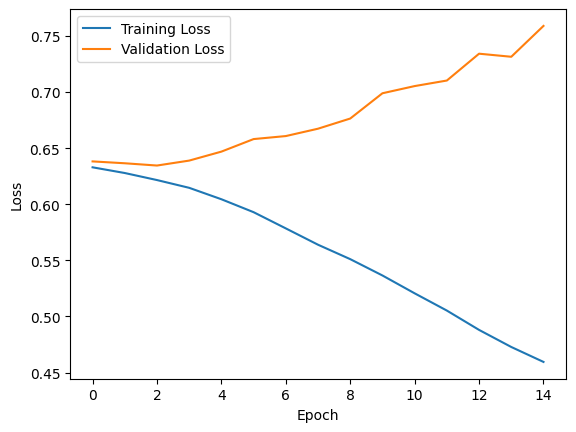

In [101]:
# Train the model and get the losses
trained_model, train_losses, dev_losses = train_nn(15, model, train_loader, dev_loader)

# Create a new figure
plt.figure()

# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(dev_losses, label='Validation Loss')

# Add labels to the axes
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a legend
plt.legend()

# Show the plot
plt.show()

The code below obtains predictions from our neural network:

In [102]:
def predict_nn(trained_model, test_loader):

    trained_model.eval()  # switch off some randomisation used during training (dropout) to give consistent predictions

    correct = 0  # count the number of correct classification labels

    gold_labs = []  # gold labels to return
    pred_labs = []  # predicted labels to return
    
    for inputs, labels in test_loader:
        test_output = trained_model(inputs)  # run the forward() function on the inputs
        predicted_labels = test_output.argmax(1)  # select the class labels with highest logits as our predictions

        gold_labs.extend(labels.tolist())
        pred_labs.extend(predicted_labels.tolist())
    
    return gold_labs, pred_labs

gold_labs, pred_labs = predict_nn(trained_model, test_loader)

In [103]:
# show the counts of distinct values in the gold_labs list
unique, counts = np.unique(gold_labs, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 620]
 [  1 240]]


Now, we can use pretrained word embeddings instead of learning them from scratch during training.
Here, we will use the pretrained GloVe embeddings that we loaded before. The embedding matrix is used to initialise the embedding layer. The code below converts the GloVe embeddings into an embedding matrix suitable for PyTorch:

In [104]:
embedding_matrix = torch.zeros((vocab_size, glove_wv.vector_size))

count = 0

for word in vocab:
    word_idx = vocab[word]
    if word in glove_wv:
        embedding_matrix[word_idx, :] = torch.from_numpy(glove_wv[word])
        count +=1 
        
print(embedding_matrix)
print(count)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
15191


The class below extends the FFTextClassifier class (it's incomplete for now -- you'll fix this in a minute!). This means that it inherits all of its functionality, but we overwrite the constructor (the `__init__` method). This way, we don't need to define the forward function again, as it will be the same as before.

The embedding layer is now different as it loads pretrained embeddings from our matrix. The argument `freeze` determines whether the embeddings remain fixed to their pretrained values (if `freeze=True`) or are updated through backpropagation to fit them to the dataset.

In [105]:
class FFTextClassifierWithEmbeddings(FFTextClassifier):

    def __init__(self, hidden_size, sequence_length, num_classes, embedding_matrix):
        super(FFTextClassifier, self).__init__()

        self.embedding_size = embedding_matrix.shape[1] 

        # Here we just need to construct the components of our network. We don't need to connect them together yet.
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=True) # embedding layer

        ### COMPLETE THE ARGUMENTS TO SPECIFY THE DIMENSIONS OF THE LAYERS
        self.hidden_layer = nn.Linear(self.embedding_size*sequence_length,hidden_size) # Hidden layer
        self.activation = nn.ReLU() # Hidden layer
        self.output_layer = nn.Linear(hidden_size, num_classes) # Full connection layer

Here we complete the arguments in the `FFTextClassifierWithEmbeddings` constructor to set the dimensions of the neural network layers.  Repeat the experiment above using the FFTextClassifierWithEmbeddings with the GLoVe embeddings. Choose a suitable performance metric and compare the performance of the two neural text classifiers.

When looking at the macro f1 score (this is a good metric because we are interested in the performance across both classes) of the two models we can see that the model using pre-trained embeddings performs worse that the model using embeddings learned from scratch. This could be a result of the corpus that is used to train GloVe word embeddings. The data we are using here is tweets where as a large amount of data used to train GloVe is from Wikipedia. This suggests that the sentient of the two is significantly different. The confusion matrices show also that both models are worse and predicted the positive class. This is likely due to the class imbalance of the training data.


Epoch: 1/15 Training Loss: 0.6509 Training Accuracy: 64.0483%
Epoch: 1/15 Validation Loss: 0.6423 Validation Accuracy: 65.3323%
Epoch: 2/15 Training Loss: 0.6262 Training Accuracy: 66.8849%
Epoch: 2/15 Validation Loss: 0.6314 Validation Accuracy: 65.4834%
Epoch: 3/15 Training Loss: 0.6149 Training Accuracy: 67.4891%
Epoch: 3/15 Validation Loss: 0.6274 Validation Accuracy: 65.7855%
Epoch: 4/15 Training Loss: 0.6002 Training Accuracy: 68.9409%
Epoch: 4/15 Validation Loss: 0.6272 Validation Accuracy: 65.9366%
Epoch: 5/15 Training Loss: 0.5827 Training Accuracy: 70.5606%
Epoch: 5/15 Validation Loss: 0.6308 Validation Accuracy: 66.5408%
Epoch: 6/15 Training Loss: 0.5644 Training Accuracy: 72.3397%
Epoch: 6/15 Validation Loss: 0.6344 Validation Accuracy: 65.6344%
Epoch: 7/15 Training Loss: 0.5488 Training Accuracy: 73.7748%
Epoch: 7/15 Validation Loss: 0.6419 Validation Accuracy: 65.7100%
Epoch: 8/15 Training Loss: 0.5315 Training Accuracy: 75.1594%
Epoch: 8/15 Validation Loss: 0.6563 Valida

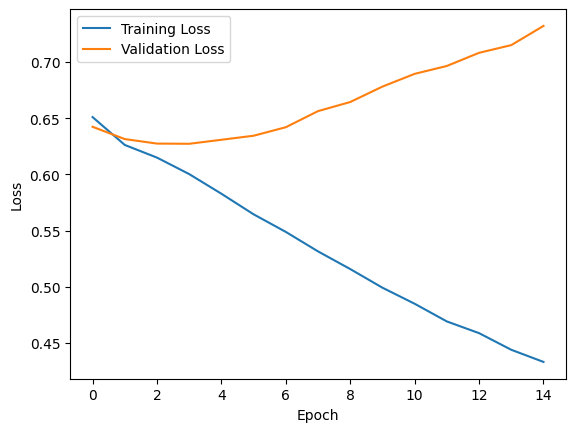

Macro F1 score with embeddings:  0.6022903781524471
Macro F1 score:  0.5938210227272728


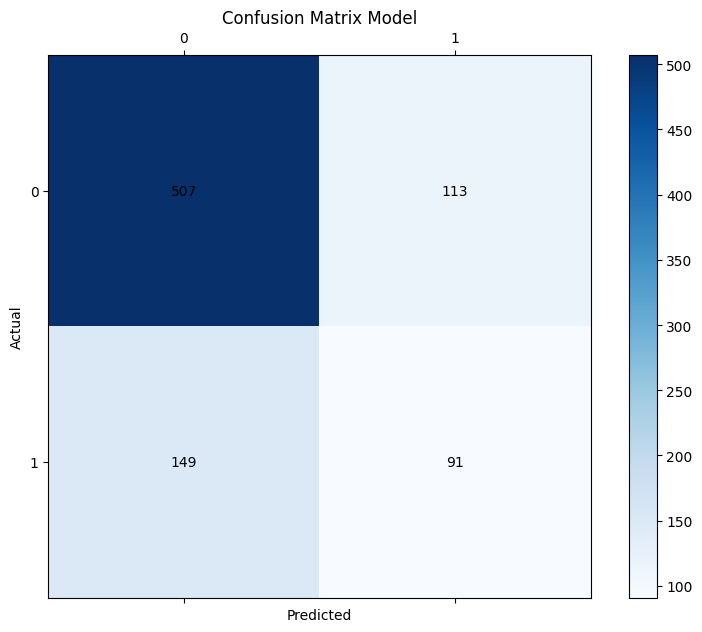

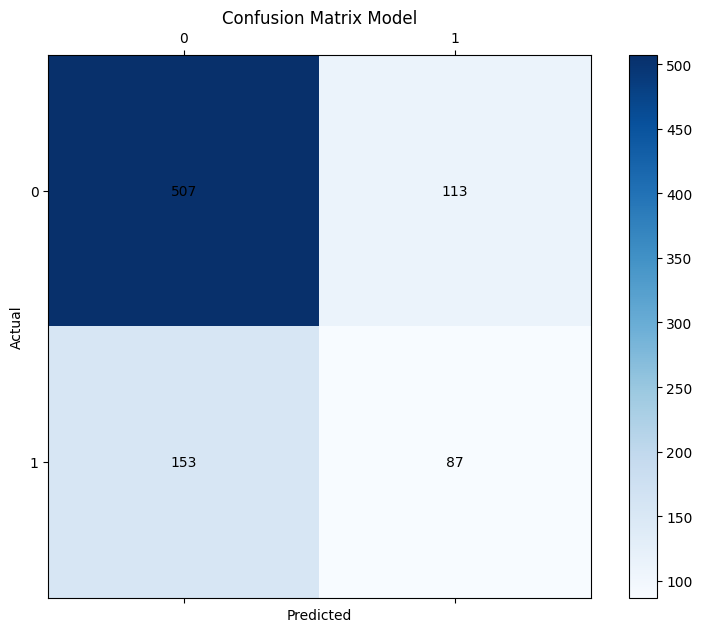

In [106]:
model_with_embeddings = FFTextClassifierWithEmbeddings(hidden_size, sequence_length, num_classes, embedding_matrix)

# Train the model and get the losses
trained_model_with_embeddings, train_losses, dev_losses = train_nn(15, model_with_embeddings, train_loader, dev_loader)

# Create a new figure
plt.figure()

# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(dev_losses, label='Validation Loss')

# Add labels to the axes
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a legend
plt.legend()

# Show the plot
plt.show()

gold_labs_with_embeddings, pred_labs_with_embeddings = predict_nn(trained_model_with_embeddings, test_loader)

from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
# roc_auc_with_embeddings = roc_auc_score(gold_labs_with_embeddings, pred_labs_with_embeddings)
macro_f1_with_embeddings = f1_score(gold_labs_with_embeddings, pred_labs_with_embeddings, average='macro')
macro_f1 = f1_score(gold_labs, pred_labs, average='macro')

print("Macro F1 score with embeddings: ", macro_f1_with_embeddings)
print("Macro F1 score: ", macro_f1)

# Generate confusion matrix
cf_with_embeddings = confusion_matrix(gold_labs_with_embeddings, pred_labs_with_embeddings)
cf = confusion_matrix(gold_labs, pred_labs)

# Plot confusion matrix
plt.figure(figsize=(10,7))
plt.matshow(cf_with_embeddings, cmap=plt.cm.Blues, fignum=1)
plt.title('Confusion Matrix Model')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
for i in range(cf_with_embeddings.shape[0]):
    for j in range(cf_with_embeddings.shape[1]):
        plt.text(j, i, cf_with_embeddings[i, j], ha='center', va='center')

# Show the plot
plt.show()

# Plot confusion matrix
plt.figure(figsize=(10,7))
plt.matshow(cf, cmap=plt.cm.Blues, fignum=1)
plt.title('Confusion Matrix Model')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
for i in range(cf.shape[0]):
    for j in range(cf.shape[1]):
        plt.text(j, i, cf[i, j], ha='center', va='center')

# Show the plot
plt.show()



# 3. Improving the Neural Text Classifier

Here we consider the neural text classifiers we have just implemented and the results you obtained in the last section. The classifiers have a number of limitations that we could improve. 


**Fine-tuning:** The orignial model use static word embeddings that are not updated during training. By allowing the pre-trained embeddings to be updated the model is able to fine-tine the embeddings for the specific task. This takes longer to train but increases performance. 

**Self-Attention:** In the first model all words in the input sequence are treated with equal importance. In many documents this is not the case, some words are more important. For example use of 'the' is often unimportant. A self-attention mechanism allows the model to assign different weights to each word representing their importance, overall improving the models understanding.

**Prevent Overfitting:** By inspecting the loss for each epoch during training in terms of validation and training sets the optimal number of epochs is selected to prevent overfitting. 




In [107]:
class FFTextClassifierEnhanced(FFTextClassifier):

    def __init__(self, hidden_size, sequence_length, num_classes, embedding_matrix, num_heads=5):
        super(FFTextClassifier, self).__init__()

        self.embedding_size = embedding_matrix.shape[1] 

        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False) # embedding layer

        # Adding a self-attention layer
        self.self_attention = nn.MultiheadAttention(embed_dim=self.embedding_size, num_heads=num_heads)

        self.hidden_layer = nn.Linear(self.embedding_size*sequence_length,hidden_size) # Hidden layer
        self.activation = nn.ReLU() # Hidden layer
        self.output_layer = nn.Linear(hidden_size, num_classes) # Full connection layer
    
    def forward (self, input_words):
        # Input dimensions are:  (batch_size, seq_length)
        embedded_words = self.embedding_layer(input_words)  # (batch_size, seq_length, embedding_size)

        # Pass the embedded words through the self-attention layer
        # Permute is used to rearrange the dimensions to (seq_length, batch_size, embedding_size) as required by nn.MultiheadAttention
        embedded_words = embedded_words.permute(1, 0, 2)
        attn_output, _ = self.self_attention(embedded_words, embedded_words, embedded_words)
        attn_output = attn_output.permute(1, 0, 2)  # rearrange dimensions back to (batch_size, seq_length, embedding_size)

        # flatten the sequence of embedding vectors for each document into a single vector.
        attn_output = attn_output.reshape(attn_output.shape[0], sequence_length*self.embedding_size)  # batch_size, seq_length*embedding_size

        z = self.hidden_layer(attn_output)   # (batch_size, hidden_size)

        h = self.activation(z)

        output = self.output_layer(h)                      # (batch_size, num_classes)

        # Notice we haven't applied a softmax activation to the output layer -- it's not required by Pytorch's loss function.

        return output

Epoch: 1/8 Training Loss: 0.6324 Training Accuracy: 66.9268%
Epoch: 1/8 Validation Loss: 0.6272 Validation Accuracy: 65.3323%
Epoch: 2/8 Training Loss: 0.6098 Training Accuracy: 66.9268%
Epoch: 2/8 Validation Loss: 0.6011 Validation Accuracy: 65.3323%
Epoch: 3/8 Training Loss: 0.5804 Training Accuracy: 69.2346%
Epoch: 3/8 Validation Loss: 0.5688 Validation Accuracy: 70.0906%
Epoch: 4/8 Training Loss: 0.5281 Training Accuracy: 74.0181%
Epoch: 4/8 Validation Loss: 0.5467 Validation Accuracy: 71.8278%
Epoch: 5/8 Training Loss: 0.4862 Training Accuracy: 76.8127%
Epoch: 5/8 Validation Loss: 0.5446 Validation Accuracy: 72.1299%
Epoch: 6/8 Training Loss: 0.4453 Training Accuracy: 79.3051%
Epoch: 6/8 Validation Loss: 0.5365 Validation Accuracy: 75.8308%
Epoch: 7/8 Training Loss: 0.4096 Training Accuracy: 81.7892%
Epoch: 7/8 Validation Loss: 0.5487 Validation Accuracy: 74.8489%
Epoch: 8/8 Training Loss: 0.3754 Training Accuracy: 83.4760%
Epoch: 8/8 Validation Loss: 0.5558 Validation Accuracy: 7

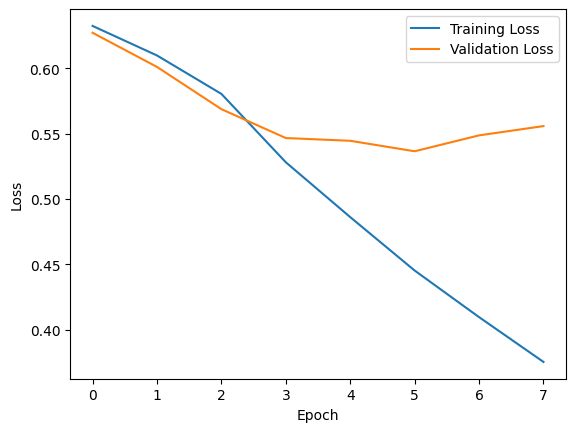

Macro F1 score enhanced:  0.7257954076219049
Macro F1 score:  0.5938210227272728


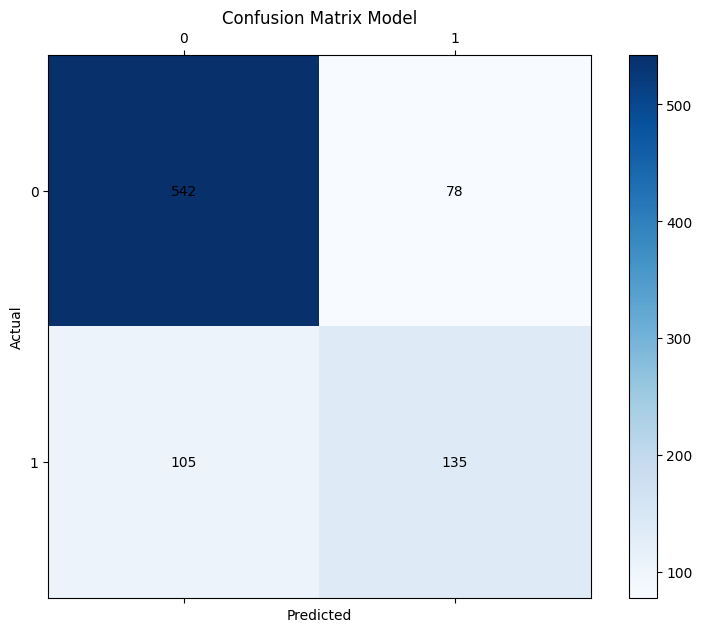

In [108]:
model_enhanced = FFTextClassifierEnhanced(hidden_size, sequence_length, num_classes, embedding_matrix)

# Train the model and get the losses
trained_model_enhanced, train_losses, dev_losses = train_nn(8, model_enhanced, train_loader, dev_loader)

# Create a new figure
plt.figure()

# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(dev_losses, label='Validation Loss')

# Add labels to the axes
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a legend
plt.legend()

# Show the plot
plt.show()

gold_labs_enhanced, pred_labs_enhanced = predict_nn(trained_model_enhanced, test_loader)

from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
# roc_auc_with_embeddings = roc_auc_score(gold_labs_with_embeddings, pred_labs_with_embeddings)
macro_f1_enhanced = f1_score(gold_labs_enhanced, pred_labs_enhanced, average='macro')
macro_f1 = f1_score(gold_labs, pred_labs, average='macro')

print("Macro F1 score enhanced: ", macro_f1_enhanced)
print("Macro F1 score: ", macro_f1)

# Generate confusion matrix
cf_enhanced = confusion_matrix(gold_labs_enhanced, pred_labs_enhanced)
cf = confusion_matrix(gold_labs, pred_labs)

# Plot confusion matrix
plt.figure(figsize=(10,7))
plt.matshow(cf_enhanced, cmap=plt.cm.Blues, fignum=1)
plt.title('Confusion Matrix Model')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
for i in range(cf_enhanced.shape[0]):
    for j in range(cf_enhanced.shape[1]):
        plt.text(j, i, cf_enhanced[i, j], ha='center', va='center')